In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from logger import Logger
from collector import Collector
from enricher import Enricher

In [2]:
# Inicialización de clases
logger = Logger()
df = pd.DataFrame()
logger.info('Main','main','Inicializar clase Logger')
collector = Collector(logger=logger)
enricher = Enricher(logger=logger)

In [3]:
# Obtener datos
df_1 = collector.collector_data()
df_2 = enricher.calcular_kpi(df_1)
df_2

c:\Users\PC\OneDrive\Documentos\Proyecto Integrador V\PIV_2025-1\src\piv\collector.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')


,fecha,apertura,alto,bajo,cerrar,cierre_ajustado,volumen,dia,mes,año,año_mes,retorno_diario,tasa_variacion_ac,retorno_acumulado,media_movil_5d,volatilidad
249,2024-05-24,467.62,479.85,466.30,478.22,476.48,12012300,24,Mayo,2024,2024-05,0.000000,0.022668,0.000000,0.000,0.000000
248,2024-05-28,476.58,480.86,474.84,479.92,478.18,10175800,28,Mayo,2024,2024-05,0.003555,0.007008,0.003555,0.000,0.000000
247,2024-05-29,474.66,479.85,473.70,474.36,472.64,9226200,29,Mayo,2024,2024-05,-0.011585,-0.000632,-0.008072,0.000,0.000000
246,2024-05-30,471.67,471.73,464.71,467.05,465.35,10735200,30,Mayo,2024,2024-05,-0.015410,-0.009795,-0.023357,0.000,0.000000
245,2024-05-31,465.80,469.12,454.46,466.83,465.13,16919800,31,Mayo,2024,2024-05,-0.000471,0.002211,-0.023817,473.276,6.125253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-05-19,628.25,643.00,627.80,640.43,640.43,9592400,19,Mayo,2025,2025-05,0.000141,0.019387,0.339195,648.008,9.034449
3,2025-05-20,636.01,639.35,632.26,637.10,637.10,6743500,20,Mayo,2025,2025-05,-0.005200,0.001714,0.332232,644.222,8.795568
2,2025-05-21,631.79,646.61,630.17,635.50,635.50,11464600,21,Mayo,2025,2025-05,-0.002511,0.005872,0.328886,639.450,3.259693
1,2025-05-22,634.05,643.25,630.71,636.57,636.57,8228400,22,Mayo,2025,2025-05,0.001684,0.003974,0.331124,637.988,2.263000


In [4]:
df_2 = enricher.calcular_kpi(df_1)
df_2.head()

,fecha,apertura,alto,bajo,cerrar,cierre_ajustado,volumen,dia,mes,año,año_mes,retorno_diario,tasa_variacion_ac,retorno_acumulado,media_movil_5d,volatilidad
249,2024-05-24,467.62,479.85,466.30,478.22,476.48,12012300,24,Mayo,2024,2024-05,0.000000,0.022668,0.000000,0.000,0.000000
248,2024-05-28,476.58,480.86,474.84,479.92,478.18,10175800,28,Mayo,2024,2024-05,0.003555,0.007008,0.003555,0.000,0.000000
247,2024-05-29,474.66,479.85,473.70,474.36,472.64,9226200,29,Mayo,2024,2024-05,-0.011585,-0.000632,-0.008072,0.000,0.000000
246,2024-05-30,471.67,471.73,464.71,467.05,465.35,10735200,30,Mayo,2024,2024-05,-0.015410,-0.009795,-0.023357,0.000,0.000000
245,2024-05-31,465.80,469.12,454.46,466.83,465.13,16919800,31,Mayo,2024,2024-05,-0.000471,0.002211,-0.023817,473.276,6.125253


In [5]:
df = df_2[["fecha", "cierre_ajustado"]]
df.set_index('fecha', inplace=True)
df.head()

,cierre_ajustado
fecha,
2024-05-24,476.48
2024-05-28,478.18
2024-05-29,472.64
2024-05-30,465.35
2024-05-31,465.13


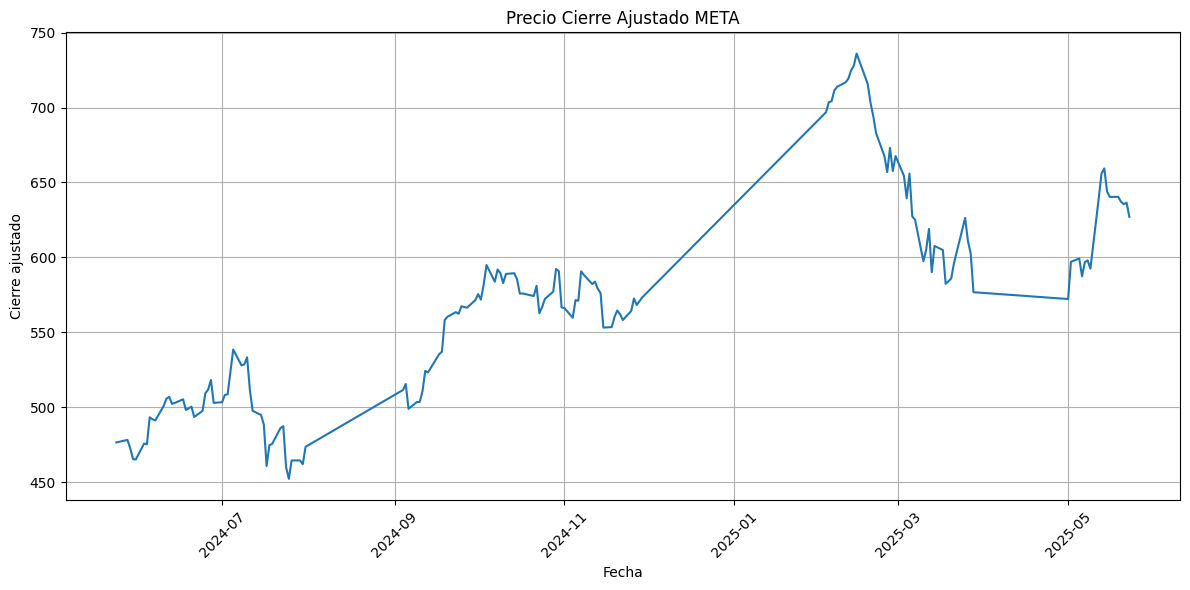

In [6]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(df.index, df['cierre_ajustado'], label='Cierre ajustado')
plt.title('Precio Cierre Ajustado META')
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

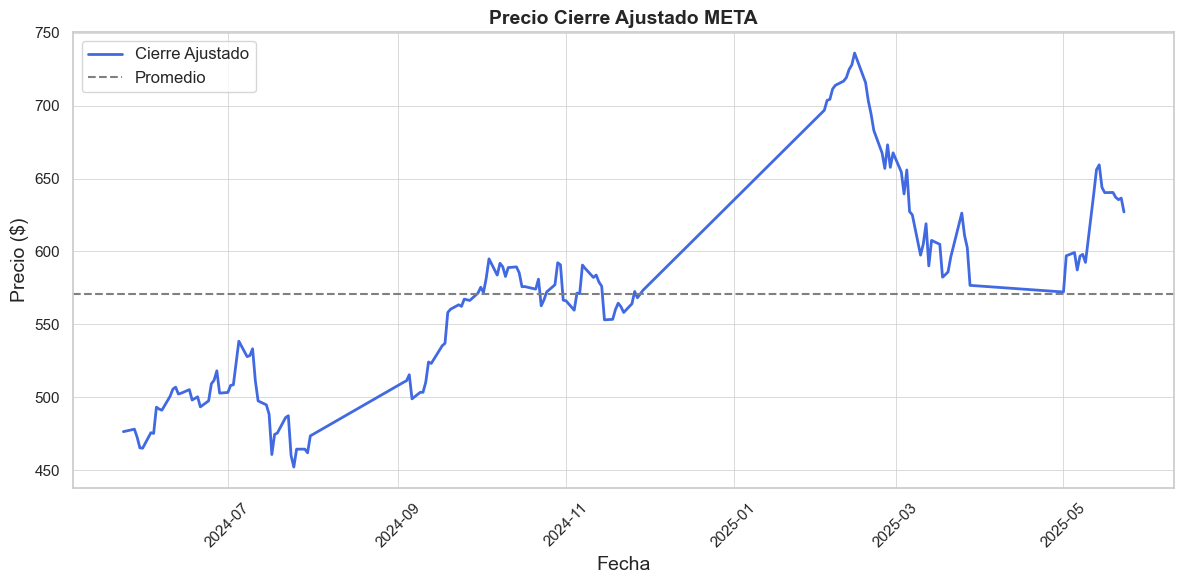

In [7]:
# Visualización con Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['cierre_ajustado'], color='royalblue', linewidth=2, label='Cierre Ajustado')

plt.title('Precio Cierre Ajustado META', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio ($)', fontsize=14)

plt.axhline(y=df['cierre_ajustado'].mean(), color='gray', linestyle='--', label='Promedio')

plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

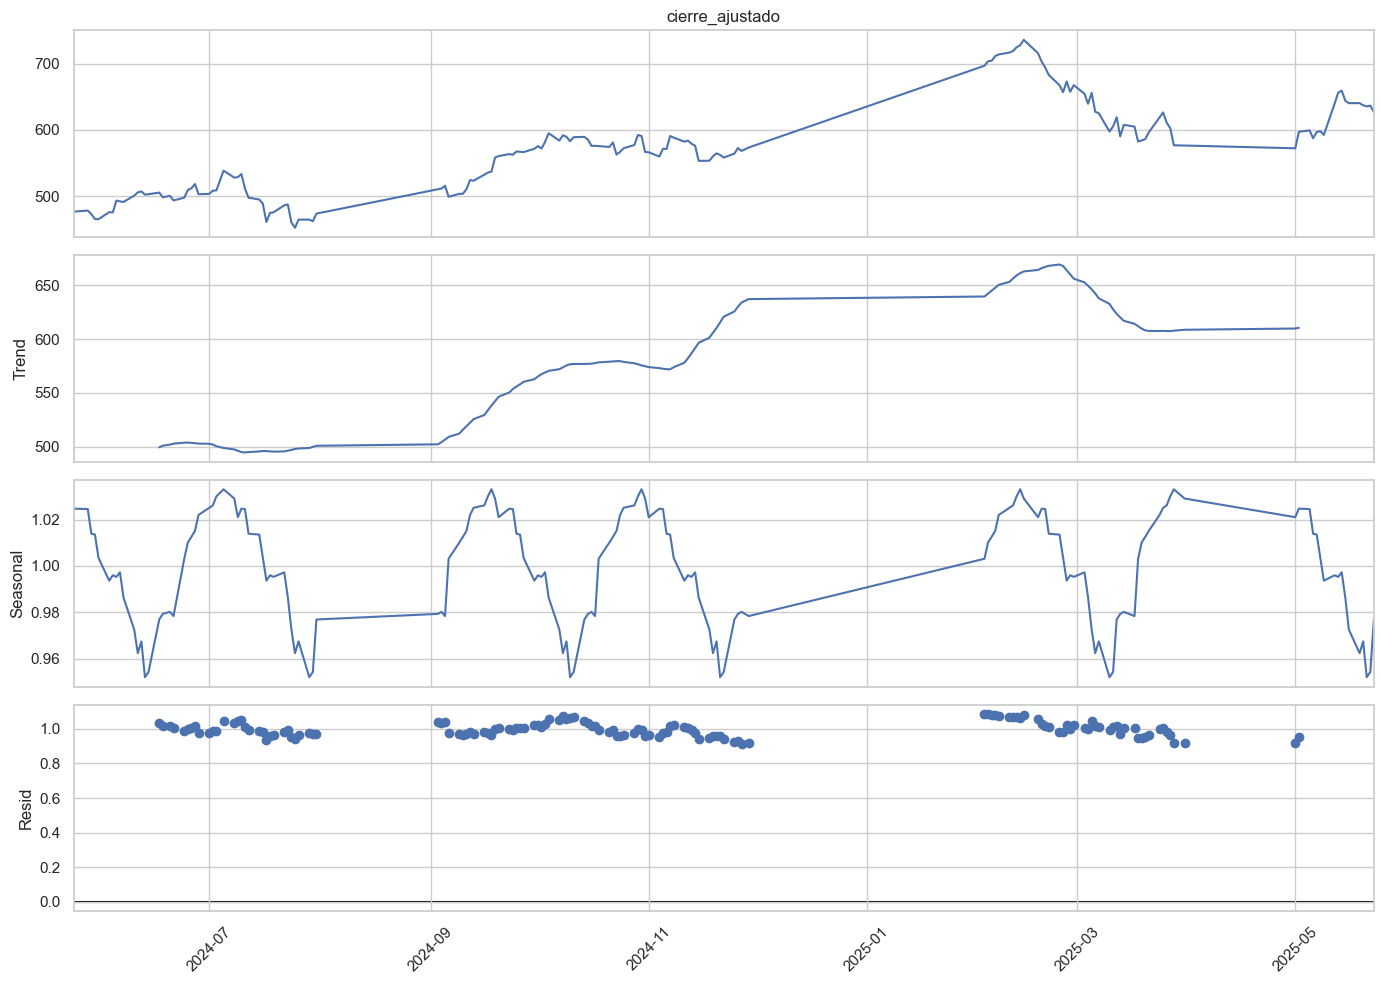

In [8]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['cierre_ajustado'], model='multiplicative', period=30)

# Graficar
fig = decomposition.plot()
fig.set_size_inches(14, 10)  # Tamaño más grande

for ax in fig.axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Mostrar cada 2 meses
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato Año-Mes
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas

plt.tight_layout()
plt.show()

In [9]:
result = adfuller(df['cierre_ajustado'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f' {key}: {value}')

if result[1] > 0.05:
    print("\nLa serie NO es estacionaria (p-valor > 0.05)")
else:
    print("\nLa serie es estacionaria (p-valor <= 0.05)")


ADF Statistic: -1.6496647353618956
p-value: 0.45721528109965826
Critical Values:
 1%: -3.470616369591229
 5%: -2.8792214018977655
 10%: -2.57619681359045

La serie NO es estacionaria (p-valor > 0.05)


In [10]:
# Serie diferenciada
df_diff = df['cierre_ajustado'].diff().dropna()
df_diff

fecha
2024-05-28     1.70
2024-05-29    -5.54
2024-05-30    -7.29
2024-05-31    -0.22
2024-06-03    10.62
              ...  
2025-05-19     0.09
2025-05-20    -3.33
2025-05-21    -1.60
2025-05-22     1.07
2025-05-23    -9.51
Name: cierre_ajustado, Length: 165, dtype: float64

In [19]:
# Con la serie diferenciada
result_diff = adfuller(df_diff)
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])
print("Critical Values:")
for key, value in result_diff[4].items():
    print(f' {key}: {value}')

if result_diff[1] > 0.05:
    print("\nLa serie diferenciada NO es estacionaria")
else:
    print("\nLa serie diferenciada es estacionaria")

ADF Statistic: -12.377303643343527
p-value: 5.1212492542238606e-23
Critical Values:
 1%: -3.47086589632514
 5%: -2.879330279087651
 10%: -2.57625492712671

La serie diferenciada es estacionaria


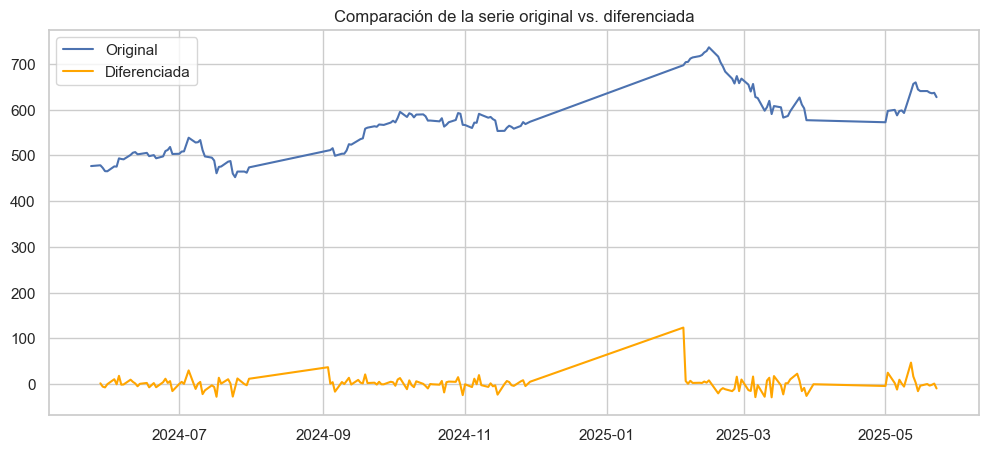

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df_diff, label='Diferenciada', color='orange')
plt.title('Comparación de la serie original vs. diferenciada')
plt.legend()
plt.grid(True)
plt.show()

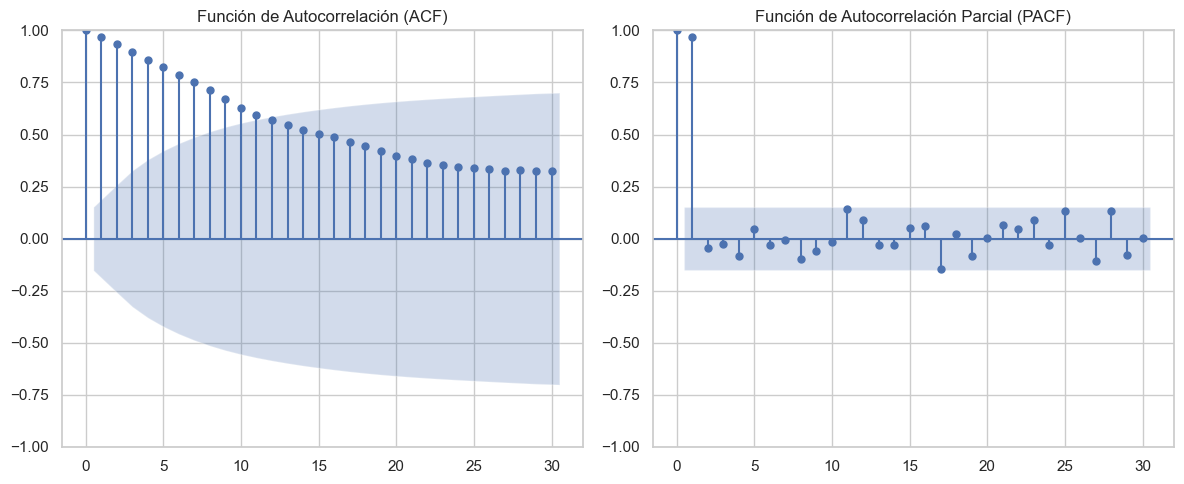

In [13]:
serie = df['cierre_ajustado']
plt.figure(figsize=(12,5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(serie, lags=30, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(serie, lags=30, ax=plt.gca(), method='ywm')  # ywm = Yule-Walker-MLE
plt.title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

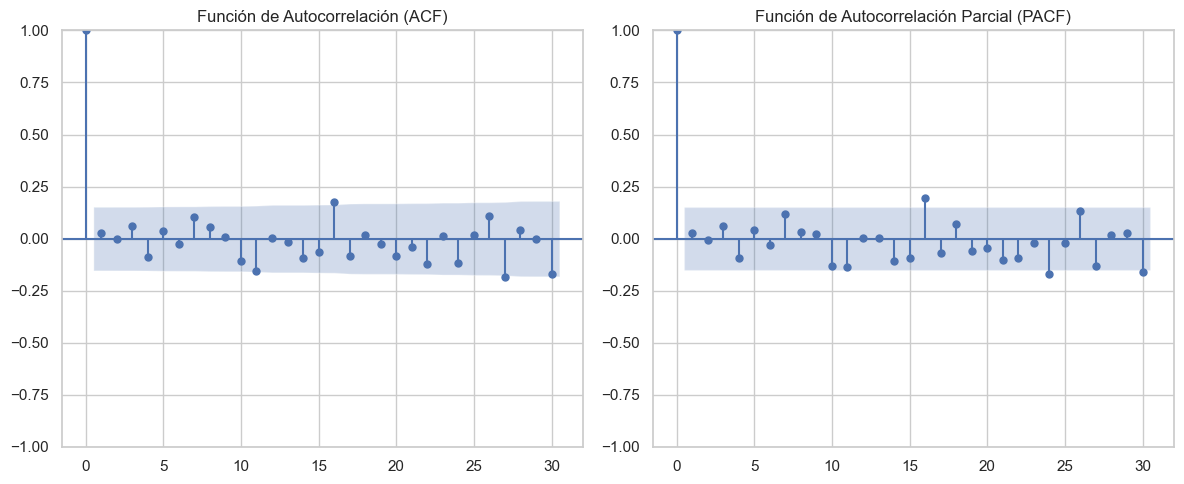

In [14]:
serie = df['cierre_ajustado']

plt.figure(figsize=(12,5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=30, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=30, ax=plt.gca(), method='ywm')
plt.title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_17004\478368722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_12'] = df['cierre_ajustado'].rolling(window=12).mean()


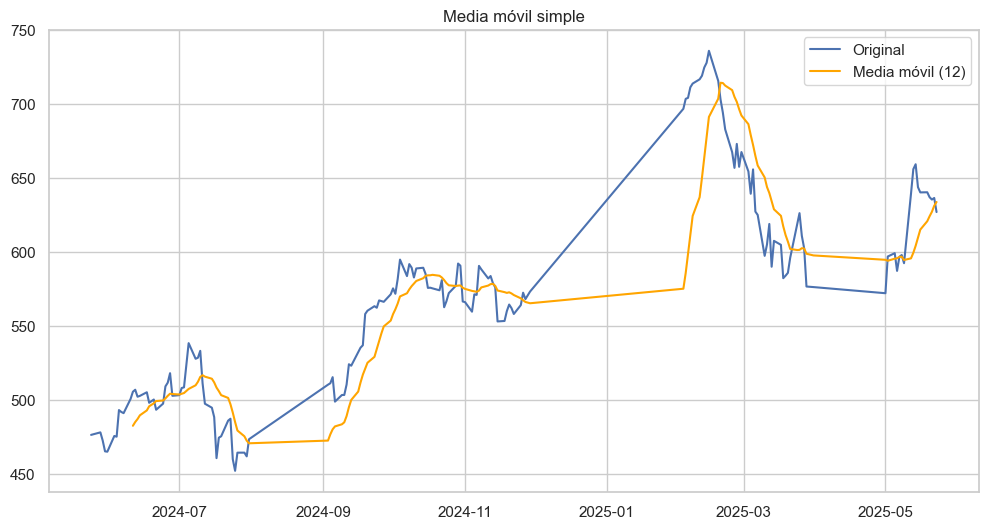

In [15]:
# Suavizado con media móvil simple (ej: ventana de 12 períodos)
df['MA_12'] = df['cierre_ajustado'].rolling(window=12).mean()

plt.figure(figsize=(12,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['MA_12'], label='Media móvil (12)', color='orange')
plt.title('Media móvil simple')
plt.legend()
plt.show()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Temp\ipykernel_17004\3493777264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SES'] = model_ses.fittedvalues


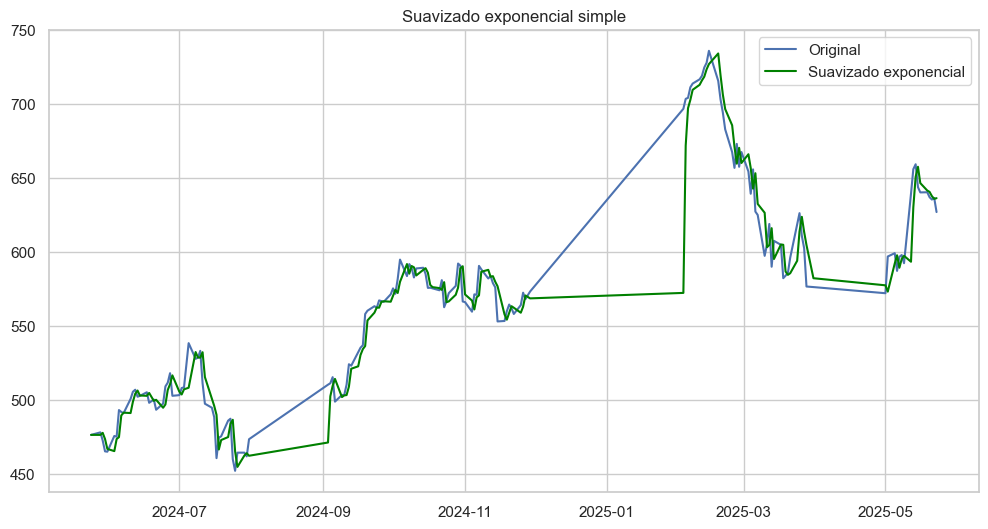

In [16]:
model_ses = SimpleExpSmoothing(df['cierre_ajustado']).fit(smoothing_level=0.8, optimized=False)
df['SES'] = model_ses.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['SES'], label='Suavizado exponencial', color='green')
plt.title('Suavizado exponencial simple')
plt.legend()
plt.show()

#### ARIMA (AutoRegressive Integrated Moving Average)

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyError: 'ARIMA_pred'

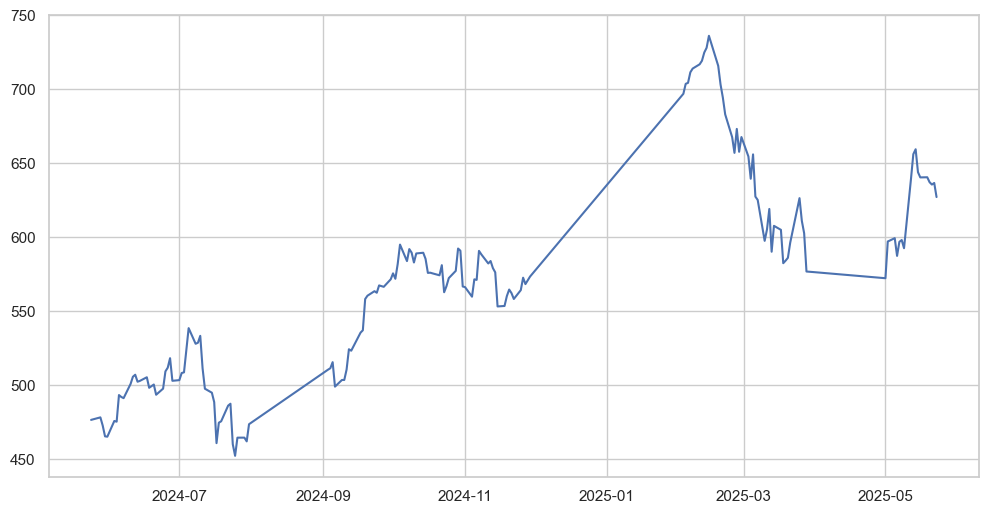

In [17]:
# Ajuste del modelo
model_arima = ARIMA(df['cierre_ajustado'], order=(1,1,1))
result_arima = model_arima.fit()

# Predicción (alineada con el índice original)
pred = result_arima.predict(start=df.index[1], end=df.index[-1], typ='levels')

# Visualización
plt.figure(figsize=(12,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['ARIMA_pred'], label='ARIMA(1,1,1)', color='red')
plt.title('Modelo ARIMA sobre cierre_ajustado')
plt.legend()
plt.show()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but i

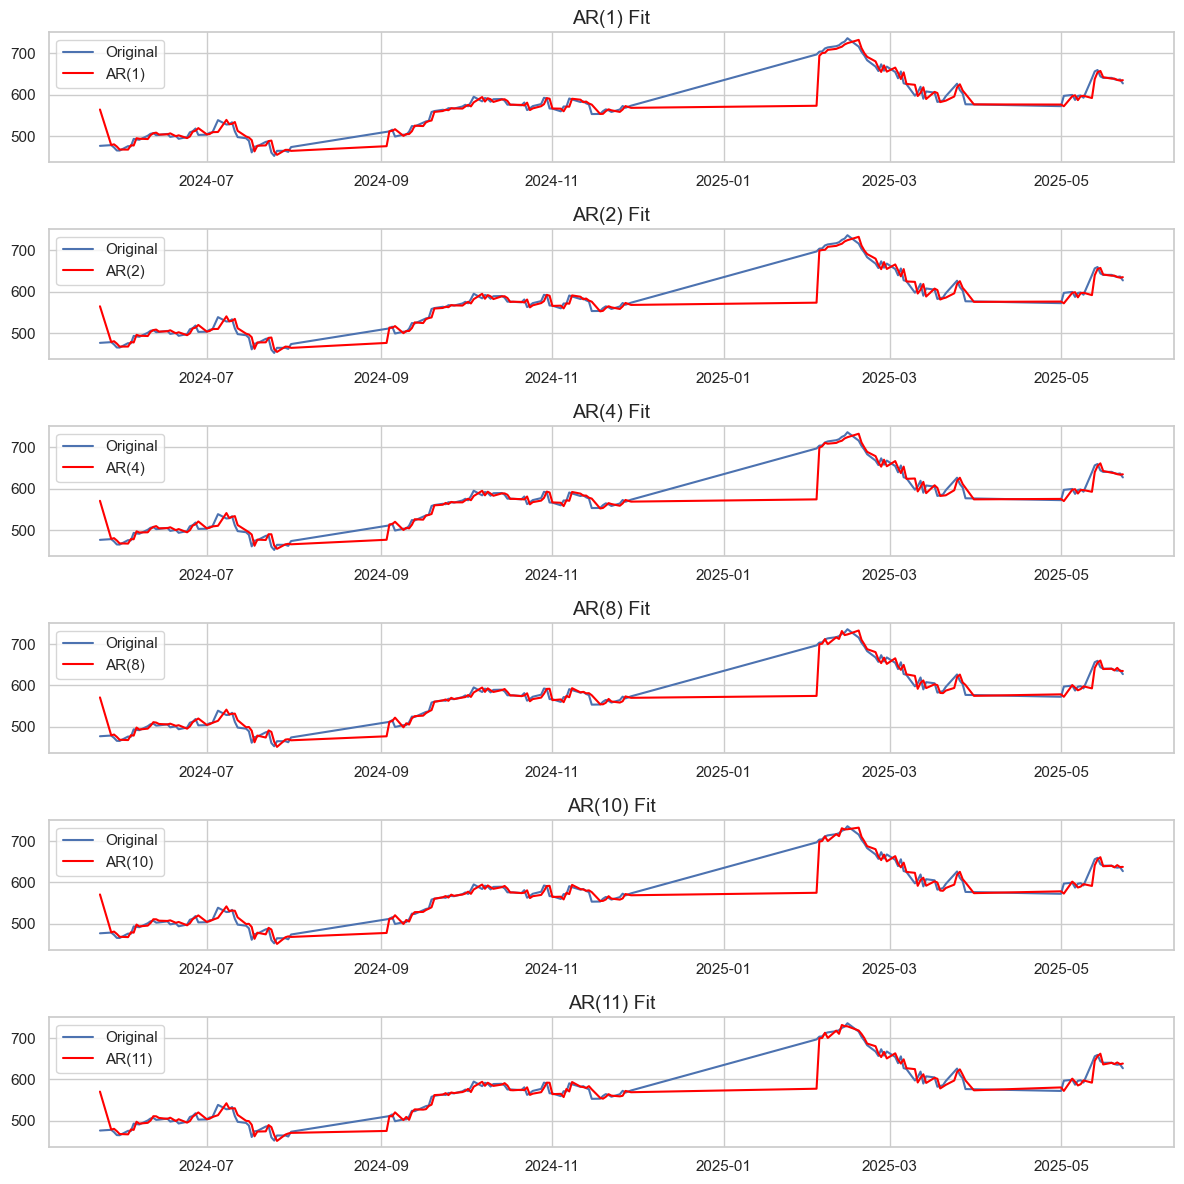

In [ ]:
ar_orders = [1, 2, 4, 8, 10, 11]

# Diccionario para guardar modelos ajustados
fitted_model_dict = {}

# Crear subplots para cada valor de p
plt.figure(figsize=(12, 12))

for idx, ar_order in enumerate(ar_orders):
    # Crear y ajustar modelo ARIMA(p,0,0)
    ar_model = ARIMA(df['cierre_ajustado'], order=(ar_order, 0, 0))
    ar_model_fit = ar_model.fit()

    # Guardar el modelo
    fitted_model_dict[ar_order] = ar_model_fit

    # Graficar
    plt.subplot(len(ar_orders), 1, idx + 1)
    plt.plot(df['cierre_ajustado'], label='Original')
    plt.plot(ar_model_fit.fittedvalues, label=f'AR({ar_order})', color='red')
    plt.title(f"AR({ar_order}) Fit", fontsize=14)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for ar_order in ar_orders:
    aic = fitted_model_dict[ar_order].aic
    print(f"AIC para AR({ar_order}): {aic}")

AIC para AR(1): 1380.332888134189
AIC para AR(2): 1382.0228680484197
AIC para AR(4): 1385.0100547599538
AIC para AR(8): 1388.2565882190643
AIC para AR(10): 1391.4140524298432
AIC para AR(11): 1391.0152304832363


In [ ]:
print("\n# Comparación de BIC")
for ar_order in ar_orders:
    bic = fitted_model_dict[ar_order].bic
    print(f"BIC para AR({ar_order}): {bic}")


# Comparación de BIC
BIC para AR(1): 1389.6688514992586
BIC para AR(2): 1394.4708192018459
BIC para AR(4): 1403.6819814900932
BIC para AR(8): 1419.3764661026298
BIC para AR(10): 1428.7579058901217
BIC para AR(11): 1431.4710717318715


#### SARIMA (Seasonal ARIMA)

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version

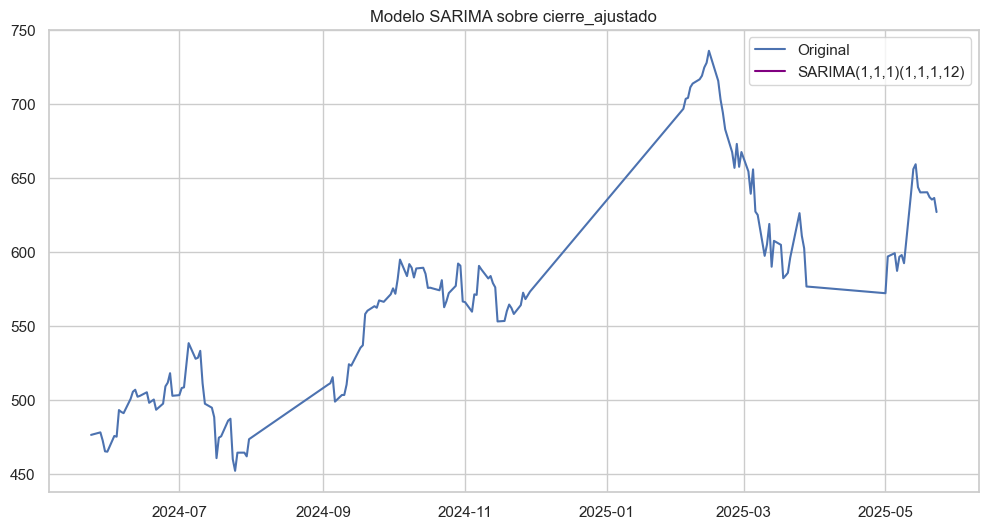

In [ ]:
model_sarima = SARIMAX(
    df['cierre_ajustado'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_sarima = model_sarima.fit()

# Predicción
df['SARIMA_pred'] = result_sarima.predict(start=1, end=len(df), typ='levels')

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['SARIMA_pred'], label='SARIMA(1,1,1)(1,1,1,12)', color='purple')
plt.title('Modelo SARIMA sobre cierre_ajustado')
plt.legend()
plt.show()